<a href="https://colab.research.google.com/github/SarahYLawrence/Implementing-Iterative-Methods/blob/Code-Phase/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
function spd_matrix(n, cond)
    # Generate a random orthogonal matrix
    Q, _ = qr(randn(n, n))
    # Generate positive eigenvalues with a given condition number
    λ_min = 1.0
    λ_max = cond
    λ = range(λ_min, λ_max, length=n)
    D = Diagonal(λ)
    # Construct SPD matrix: A = Q * D * Q'
    A = Q * D * Q'
    return Symmetric(A)
end

spd_matrix (generic function with 1 method)

In [46]:
# conjugate gradient
function conjugate_gradient(A, b; x0=zero(b), tol=1e-8, maxiter=1000)
    x = copy(x0) # current estimate
    r = b - A * x # residual: how far x is from the true solution
    p = copy(r) # search direction
    rs_old = dot(r, r) # squared norm of the residual

    residuals = [sqrt(rs_old)] # store the first residual

    for k in 1:maxiter
        Ap = A * p  # determine the best step size
        alpha = rs_old / dot(p, Ap) # optimal step length along direction p
        x += alpha * p # move in direction p by amount α
        r -= alpha * Ap # update residual

        # Check Convergence: If residual norm is small enough, CG has converged
        rs_new = dot(r, r)
        push!(residuals, sqrt(rs_new))
        if sqrt(rs_new) < tol
            println("Converged in $k iterations")
            return x, residuals
        end

        beta = rs_new / rs_old  # how much of the previous direction is kept

        # Update Search Direction
        p = r + beta * p
        rs_old = rs_new
    end
    # incase max iterations are reached
    println("Max iterations reached")
    return x, residuals
end


conjugate_gradient (generic function with 1 method)

In [48]:
using Random, LinearAlgebra

# Fix the seed
Random.seed!(123)  # <- same seed every time

# Define your SPD matrices and vector b
n = 5
A1 = spd_matrix(n, 10)
A2 = spd_matrix(n, 1000)
A3 = spd_matrix(n, 10000000)
b = randn(n)  # this will always be the same with the same seed

# Run conjugate gradient
x1, res1 = conjugate_gradient(A1, b)
x2, res2 = conjugate_gradient(A2, b)
x3, res3 = conjugate_gradient(A3, b)


Converged in 5 iterations
Converged in 5 iterations
Converged in 6 iterations


([-0.27415982529944183, 0.299153612168632, -0.24148690370867093, -0.2276383249799407, 0.18287179081250154], [1.70277456031669, 0.6304838107801, 1.7100897877579986, 4.8949016833735435, 133.62264543683008, 4.288019066176263e-8, 2.75486980954971e-9])

Converged in 5 iterations
Converged in 5 iterations
Converged in 6 iterations


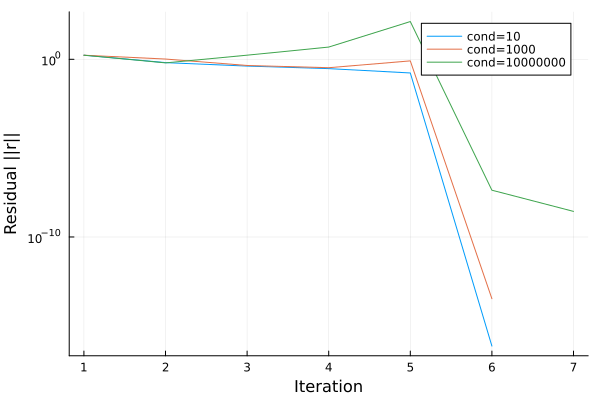

"/content/cg_residuals.png"

In [47]:
using Plots
gr()

x1, res1 = conjugate_gradient(A1, b)
x2, res2 = conjugate_gradient(A2, b)
x3, res3 = conjugate_gradient(A3, b)

plt = plot(1:length(res1), res1, yscale=:log10, label="cond=10",
           xlabel="Iteration", ylabel="Residual ||r||")
plot!(plt, 1:length(res2), res2, label="cond=1000")
plot!(plt, 1:length(res3), res3, label="cond=10000000")

display(plt)
savefig(plt, "cg_residuals.png")

In [23]:
using LinearAlgebra

function gmres_residuals(A, b; x0=zero(b), tol=1e-8, maxiter=100)
    n = length(b) # number of entries in the vector b
    x = copy(x0) # current estimate
    r0 = b - A*x # initial residual
    beta = norm(r0) # magnitude of that initial error

    residuals = [beta] # residuals array stores the norms at each step

    # immediately exits if the initial guess is already accurate
    if beta < tol
        return x, residuals
    end

    # Arnoldi process
    V = zeros(n, maxiter+1) # basis vectors
    H = zeros(maxiter+1, maxiter) # upper Hessenberg matrix
    V[:,1] = r0 / beta # orthonormal basis vector

    for j in 1:maxiter
        w = A * V[:,j]
        # modified Gram–Schmidt
        for i in 1:j
            H[i,j] = dot(V[:,i], w)
            w -= H[i,j] * V[:,i]
        end
        # new basis vector
        H[j+1,j] = norm(w)
        if H[j+1,j] != 0
            V[:,j+1] = w / H[j+1,j]
        end

        # solve least squares min ||beta e1 - H y||
        e1 = zeros(j+1); e1[1] = beta
        y = H[1:j+1,1:j] \ e1
        x_approx = x0 + V[:,1:j]*y

        # residual norm for plotting
        res = norm(b - A*x_approx)
        push!(residuals, res)

        # check convergence
        if res < tol
            println("GMRES converged in $j iterations")
            return x_approx, residuals
        end
    end
    println("GMRES max iterations reached")
    return x_approx, residuals
end


gmres_residuals (generic function with 1 method)

In [32]:
using Random

n = 5
Random.seed!(123)

A1 = spd_matrix(n, 10)    # well-conditioned
A2 = spd_matrix(n, 1000)  # ill-conditioned
A3 = spd_matrix(n, 10000000)  # ill-conditioned
b = randn(n)

x1, res1 = gmres_residuals(A1, b)
x2, res2 = gmres_residuals(A2, b)
x3, res3 = gmres_residuals(A3, b)

GMRES converged in 5 iterations
GMRES converged in 5 iterations
GMRES converged in 5 iterations


([-0.2741598252356262, 0.299153612098999, -0.24148690365246064, -0.2276383249269539, 0.18287179076993482], [1.70277456031669, 0.5912550235929177, 0.5587983440652987, 0.555192328203559, 0.5551875360070435, 1.3121926950500375e-9])

GMRES converged in 5 iterations
GMRES converged in 5 iterations
GMRES converged in 5 iterations


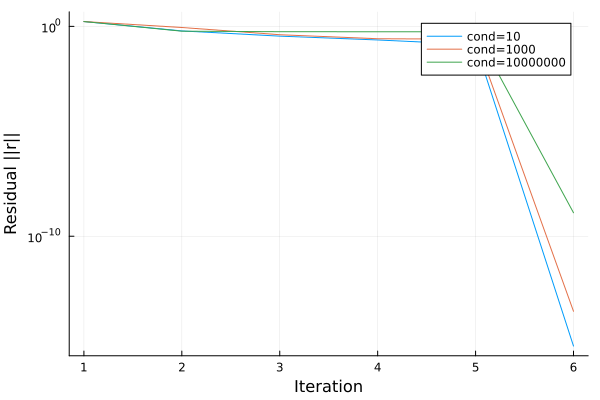

"/content/gmres_residuals.png"

In [38]:
using Plots
gr()

x1, res1 = gmres_residuals(A1, b)
x2, res2 = gmres_residuals(A2, b)
x3, res3 = gmres_residuals(A3, b)

plt = plot(1:length(res1), res1, yscale=:log10, label="cond=10", xlabel="Iteration", ylabel="Residual ||r||")
plot!(plt, 1:length(res2), res2, label="cond=1000")  # yscale log10 already set
plot!(plt, 1:length(res3), res3, label="cond=10000000")  # yscale log10 already set

display(plt)
savefig(plt, "gmres_residuals.png")


In [25]:
using LinearAlgebra

function bicgstab_residuals(A, b; x0=zero(b), tol=1e-8, maxiter=1000)
    n = length(b)
    x = copy(x0) # current approximation of the solution
    r = b - A*x # residual
    r_hat = copy(r) # fixed copy of the initial residual (used for or computing scalars)
    rho_old = alpha = omega = 1.0 # scalars initialized to 1
    v = zeros(n) #  auxiliary vector used in the iterations
    p = zeros(n) # auxiliary vector used in the iterations

    residuals = [norm(r)] # list storing the norm of the residual at each step

    for k in 1:maxiter
        rho = dot(r_hat, r) # control the search direction update
        # the method breaks down because a division by zero
        if rho == 0
            println("Breakdown: rho=0")
            break
        end
        # update the search direction p
        if k == 1
            p = r
        else
            beta = (rho/rho_old) * (alpha/omega)
            p = r + beta*(p - omega*v)
        end

        v = A*p # matrix-vector product
        alpha = rho / dot(r_hat, v) # reduce the residual in the current direction
        s = r - alpha*v # residual after moving
        t = A*s # stabilize the correction step
        omega = dot(t,s)/dot(t,t)
        x += alpha*p + omega*s
        r = s - omega*t

        push!(residuals, norm(r)) # residual norm is saved for plotting or analysis.

        # if residual is below the tolerance then stop
        if norm(r) < tol
            println("BiCGSTAB converged in $k iterations")
            return x, residuals
        end

        # check breakdown
        # if omega = 0, the algorithm cannot continue.
        if omega == 0
            println("Breakdown: omega=0")
            break
        end

        rho_old = rho # is updated for the next iteration
    end
    println("BiCGSTAB max iterations reached")
    return x, residuals
end


bicgstab_residuals (generic function with 1 method)

In [27]:
Random.seed!(123)

A1 = spd_matrix(n, 10)    # well-conditioned
A2 = spd_matrix(n, 1000)  # ill-conditioned
A3 = spd_matrix(n, 10000000)
b = randn(n)

x1, res1 = bicgstab_residuals(A1, b)
x2, res2 = bicgstab_residuals(A2, b)
x3, res3 = bicgstab_residuals(A3, b)


BiCGSTAB converged in 5 iterations
BiCGSTAB converged in 5 iterations
BiCGSTAB converged in 5 iterations


([-0.2741598268039143, 0.2991536138102591, -0.24148690503384795, -0.22763832622912222, 0.1828717918160246], [1.70277456031669, 0.558808851953471, 0.577422216863759, 0.5774852931976713, 0.5628588533250882, 3.095944622007877e-9])

BiCGSTAB converged in 5 iterations
BiCGSTAB converged in 5 iterations
BiCGSTAB converged in 5 iterations


[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling GRIJuliaExt [84369c5d-ffb2-5a92-8288-3470980d96d0] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (2))


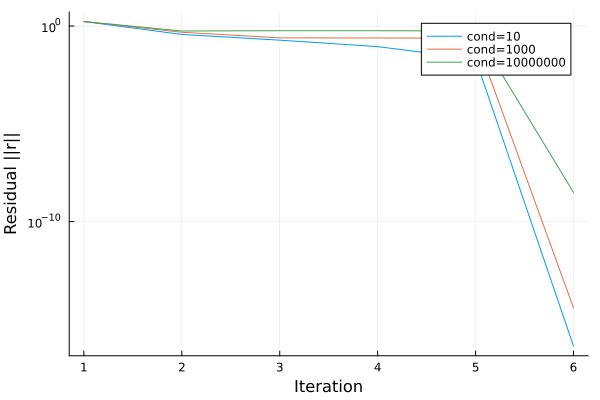

"/content/bicgstab_residuals.png"

In [34]:
using Plots
gr()

x1, res1 = bicgstab_residuals(A1, b)
x2, res2 = bicgstab_residuals(A2, b)
x3, res3 = bicgstab_residuals(A3, b)

plt = plot(1:length(res1), res1, yscale=:log10, label="cond=10", xlabel="Iteration", ylabel="Residual ||r||")
plot!(plt, 1:length(res2), res2, label="cond=1000")  # yscale log10 already set
plot!(plt, 1:length(res3), res3, label="cond=10000000")  # yscale log10 already set

display(plt)
savefig(plt, "bicgstab_residuals.png")


In [50]:
# CG
x1_cg, res1_cg = conjugate_gradient(A1, b)
x2_cg, res2_cg = conjugate_gradient(A2, b)
x3_cg, res3_cg = conjugate_gradient(A3, b)

# GMRES
x1_gm, res1_gm = gmres_residuals(A1, b)
x2_gm, res2_gm = gmres_residuals(A2, b)
x3_gm, res3_gm = gmres_residuals(A3, b)

# BiCGSTAB
x1_bi, res1_bi = bicgstab_residuals(A1, b)
x2_bi, res2_bi = bicgstab_residuals(A2, b)
x3_bi, res3_bi = bicgstab_residuals(A3, b)

# Extract final residuals
final_res_cg_10    = res1_cg[end]
final_res_cg_1000  = res2_cg[end]
final_res_cg_100000  = res3_cg[end]
println(final_res_cg_10)
println(final_res_cg_1000)
println(final_res_cg_100000)

final_res_gm_10    = res1_gm[end]
final_res_gm_1000  = res2_gm[end]
final_res_gm_100000  = res3_gm[end]
println(final_res_gm_10)
println(final_res_gm_1000)
println(final_res_gm_100000)

final_res_bi_10    = res1_bi[end]
final_res_bi_1000  = res2_bi[end]
final_res_bi_100000  = res3_bi[end]
println(final_res_bi_10)
println(final_res_bi_1000)
println(final_res_bi_100000)


Converged in 5 iterations
Converged in 5 iterations
Converged in 6 iterations
GMRES converged in 5 iterations
GMRES converged in 5 iterations
GMRES converged in 5 iterations
BiCGSTAB converged in 5 iterations
BiCGSTAB converged in 5 iterations
BiCGSTAB converged in 5 iterations
7.254795259789033e-17
3.353588026452685e-14
2.75486980954971e-9
5.823712417406891e-16
2.6472217637014605e-14
1.3121926950500375e-9
4.284514564752239e-17
3.845108713908289e-15
3.095944622007877e-9


In [53]:
t_cg_10 = @elapsed x1_cg, res1_cg = conjugate_gradient(A1, b)
t_cg_1000 = @elapsed x2_cg, res2_cg = conjugate_gradient(A2, b)
t_cg_100000 = @elapsed x3_cg, res3_cg = conjugate_gradient(A3, b)

t_gm_10 = @elapsed x1_gm, res1_gm = gmres_residuals(A1, b)
t_gm_1000 = @elapsed x2_gm, res2_gm = gmres_residuals(A2, b)
t_gm_100000 = @elapsed x3_gm, res3_gm = gmres_residuals(A3, b)

t_bi_10 = @elapsed x1_bi, res1_bi = bicgstab_residuals(A1, b)
t_bi_1000 = @elapsed x2_bi, res2_bi = bicgstab_residuals(A2, b)
t_bi_100000 = @elapsed x3_bi, res3_bi = bicgstab_residuals(A3, b)


Converged in 5 iterations
Converged in 5 iterations
Converged in 6 iterations
GMRES converged in 5 iterations
GMRES converged in 5 iterations
GMRES converged in 5 iterations
BiCGSTAB converged in 5 iterations
BiCGSTAB converged in 5 iterations
BiCGSTAB converged in 5 iterations


0.000196609

In [54]:
println("CG time (cond=10): ", t_cg_10)
println("CG time (cond=1000): ", t_cg_1000)
println("CG time (cond=100000): ", t_cg_100000)

println("GMRES time (cond=10): ", t_gm_10)
println("GMRES time (cond=1000): ", t_gm_1000)
println("GMRES time (cond=100000): ", t_gm_100000)

println("BiCGSTAB time (cond=10): ", t_bi_10)
println("BiCGSTAB time (cond=1000): ", t_bi_1000)
println("BiCGSTAB time (cond=100000): ", t_bi_100000)


CG time (cond=10): 0.00017936
CG time (cond=1000): 0.000193159
CG time (cond=100000): 0.00017218
GMRES time (cond=10): 0.00034327
GMRES time (cond=1000): 0.00032296
GMRES time (cond=100000): 0.000315389
BiCGSTAB time (cond=10): 0.00017917
BiCGSTAB time (cond=1000): 0.0002079
BiCGSTAB time (cond=100000): 0.000196609
